## Geospatial Coding With Cleveland's Open Data Portal
**This notebook will teach you the following:**
* How to programatically access data using the [ArcGIS Online API for Python](https://developers.arcgis.com/python/latest/).
* How to convert that data into a [geopandas GeoDataFrame](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.html).
* How to plot spatial data on a map using the [`.plot`](https://geopandas.org/en/stable/docs/user_guide/mapping.html) function.
* How to perform a spatial join using the [`.sjoin`](https://geopandas.org/en/stable/docs/reference/api/geopandas.sjoin.html) function.
* Analyze and visualize your data using `geopandas` and `seaborn`.

#### Step 1: Setup your environment
Before you start, you'll the following packages:
* [`geopandas`](https://geopandas.org/en/stable/)
* [`arcgis`](https://developers.arcgis.com/python/latest/)
* [`seaborn`](https://seaborn.pydata.org/index.html)  

`geopandas` is a package that allows you to work with spatial data in Python. `geopandas` is built off of the `pandas` package, which is most commonly used data analysis package for Python. `pandas` uses what are called `DataFrames` to store data. [Click here](https://www.w3schools.com/python/pandas/pandas_dataframes.asp) to learn more about `DataFrames`. `geopandas` takes the concept of a `DataFrame` a step further, by introducing what is known as a [`GeoDataFrame`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.html). `GeoDataFrames` are capable of storing spatial information (i.e Points, Polygons, and Lines) in addition to other data.

`arcgis` is a wrapper for the [ArcGIS Online REST API](https://developers.arcgis.com/rest/). Since Cleveland's Open Data Portal is built on ArcGIS Online, we can use this package to programatically connect to and access data from the service.

If you don't already have these packages installed, you can install them using the following code in the command line:  

```
pip install geopandas
pip install arcgis
pip install seaborn
```  

[Click here](https://packaging.python.org/en/latest/tutorials/installing-packages/) to learn more about installing packages in Python.

In [0]:
import geopandas as gpd
import arcgis
import seaborn as sns

#### Step 2: Load in data using the `arcgis` package
We will be using two datasets from [Cleveland Open Data](data.clevelandohio.gov) for this analysis:  

[**Cleveland Traffic Crashes**](https://data.clevelandohio.gov/datasets/44239d50c4f448dc9789ff4f7739e524_62/explore?location=41.510315%2C-81.727496%2C9.76)
>Point layer of all Cleveland crash locations exported from Ohio Department of Transportation (ODOT) GIS Crash Analysis Tool (GCAT).

[**Cleveland Neighborhoods**](https://data.clevelandohio.gov/datasets/b2a2da54401a41e78dd71563f01f5273_0/explore?location=41.504856%2C-81.709890%2C11.84)
>Reference boundaries of Cleveland neighborhoods, which are also referred to as Statisical Planning Areas (SPAs).

As previously mentioned, we will access this data using the [ArcGIS Online API for Python](https://developers.arcgis.com/python/latest/). This will be achieved in 5 steps.

First, load in the [*FeatureService*](https://developers.arcgis.com/rest/services-reference/enterprise/feature-service/) for the dataset using the service's REST URL:

In [0]:
# First we will need the URL to the FeatureService
crashes_service_url = "https://services3.arcgis.com/dty2kHktVXHrqO8i/arcgis/rest/services/Cleveland_Traffic_Crashes_view/FeatureServer/62/"

# Then we will connect to the service using the ArcGIS Online API
crashes_featureservice = arcgis.features.FeatureLayer(crashes_service_url)
print(crashes_featureservice)

<FeatureLayer url:"https://services3.arcgis.com/dty2kHktVXHrqO8i/arcgis/rest/services/Cleveland_Traffic_Crashes_view/FeatureServer/62">


Query the *FeatureService* to access its underlying data. In ArcGIS, this data structure is called a [*FeatureSet*](https://developers.arcgis.com/rest/services-reference/enterprise/featureset-object/), which is a collection of [*Features*](https://developers.arcgis.com/rest/services-reference/enterprise/feature-object/):

In [0]:
# Once we've connected to the FeatureService, we can query it to get the actual data.
crashes_featureset = crashes_featureservice.query()

IOStream.flush timed out


Extract the [*Coordinate Reference System*](https://en.wikipedia.org/wiki/Spatial_reference_system) (CRS) from the *FeatureSet*. This will allow for us to know *how* the data is mapped on the Earth's surface:

In [0]:
# Let's get the Coordinate Reference System (CRS) from the above FeatureSet
crashes_crs = crashes_featureset.spatial_reference['latestWkid']
print(f"The EPSG ID of the CRS is {crashes_crs}")

The EPSG ID of the CRS is 3734


Extract a `DataFrame` from the *FeatureSet* using the *FeatureSet*'s `.sdf` property:

In [0]:
# Lastly, lets get the DataFrame from the FeatureSet, this is contained in the .sdf property of the FeatureSet. 
crashes_sdf = crashes_featureset.sdf
crashes_sdf.head()

,OBJECTID,DOCUMENT_NBR,CRASH_YR,CRASH_MONTH_YEAR,DISTRICT_NBR,NLFID,NLF_JUR_CD,NLF_COUNTY_CD,COUNTY_LOG_NBR,ODOT_LATITUDE_NBR,ODOT_LONGITUDE_NBR,ODOT_FIPS_CD,AREA_CODE,CRASH_DATE,CRASH_SEVERITY_CD,CRASH_TYPE_CD,DAY_IN_WEEK_CD,DISTRACTED_DRIVER_IND,FACILITY_TYPE_CD,FHWA_RDWY_DEPARTURE_IND,FREEWAY_IND,FUNCTIONAL_CLASS_CD,HOUR_OF_CRASH,INCAPAC_INJURIES_NBR,INTERCHANGE_ID,INTERSECTION_ID_CURRENT,INTERSECTION_LEG_ID,INTERSTATE_IND,INV_LOG_NBR,INV_NLFID,IS_COMMERCIAL_RELATED,LIGHT_COND_PRIMARY_CD,LOCAL_REPORT_NUMBER_ID,MAINTENANCE_AUTHORITY_CD,MONTH_OF_CRASH,NHS_CD,NO_INJURY_REPORTED_NBR,NON_INCAPAC_INJURIES_NBR,NUMBER_OF_UNITS_NBR,ODOT_CITY_VILLAGE_TWP_NME,...,U1_TRAFFIC_CONTROL_CD,U1_TURN_CD,U1_TYPE_OF_UNIT_CD,U1_UNIT_SPEED_NBR,U2_AGE_NBR,U2_CONT_CIR_PRIMARY_CD,U2_DIRECTION_FROM_CD,U2_DIRECTION_TO_CD,U2_DISTRACTED_BY_1_CD,U2_GENDER_CD,U2_NON_MOTORIST_LOC_CD,U2_ODPS_UNIT_NBR,U2_POSTED_SPEED_NBR,U2_PRECRASH_ACTION_CD,U2_SEQ_OF_EVENTS_1_CD,U2_SEQ_OF_EVENTS_2_CD,U2_SEQ_OF_EVENTS_3_CD,U2_SEQ_OF_EVENTS_4_CD,U2_SEQ_OF_EVENTS_5_CD,U2_SEQ_OF_EVENTS_6_CD,U2_SPECIAL_FUNCTION_CD,U2_TRAFFIC_CONTROL_CD,U2_TURN_CD,U2_TYPE_OF_UNIT_CD,U2_UNIT_SPEED_NBR,U3_CONT_CIR_PRIMARY_CD,U3_ODPS_UNIT_NBR,U3_PRECRASH_ACTION_CD,U3_SEQ_OF_EVENTS_1_CD,U3_SEQ_OF_EVENTS_2_CD,U3_SEQ_OF_EVENTS_3_CD,U3_SEQ_OF_EVENTS_4_CD,U3_SEQ_OF_EVENTS_5_CD,U3_SEQ_OF_EVENTS_6_CD,U3_SPECIAL_FUNCTION_CD,U3_TRAFFIC_CONTROL_CD,U3_TYPE_OF_UNIT_CD,UNRESTRAIN_OCCUPANTS,WEATHER_COND_CD,SHAPE
0,1,20174001939.0,2017.0,1/1/2017 12:00:00 AM,12.0,CCUYCR00398**C,C,CUY,0.844,41.451878,-81.621368,16000,17668,1/19/2017 12:00:00 AM,5.0,5.0,5.0,N,<NA>,N,N,4.0,14.0,0.0,<NA>,97fca815-7530-4e41-89fc-f3d30d184b47,5603e287-f6d5-46d4-b8f1-de3082166e10,N,0.844,CCUYCR00398**C,Y,1.0,00912,4.0,1.0,<NA>,2.0,0.0,2.0,CLEVELAND,...,6.0,NT,19.0,20.0,55.0,1.0,1.0,2.0,1.0,F,<NA>,1.0,25.0,11.0,20.0,<NA>,<NA>,<NA>,<NA>,<NA>,4.0,6.0,NT,19.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0.0,1.0,"{""x"": 2209355.6854842156, ""y"": 651613.02818214..."
1,2,20174001941.0,2017.0,1/1/2017 12:00:00 AM,12.0,CCUYCR00721**C,C,CUY,0.579,41.499732,-81.680842,16000,17668,1/20/2017 12:00:00 AM,3.0,8.0,6.0,N,<NA>,N,N,5.0,6.0,0.0,<NA>,5fe1d5c8-fa09-4373-8d94-334e1fd2392d,58b206d5-f2d5-4b30-b01a-2d379cf3a123,N,0.579,CCUYCR00721**C,Y,2.0,00911,4.0,1.0,<NA>,1.0,1.0,2.0,CLEVELAND,...,2.0,NT,23.0,3.0,48.0,1.0,1.0,9.0,1.0,M,<NA>,1.0,25.0,6.0,14.0,<NA>,<NA>,<NA>,<NA>,<NA>,1.0,2.0,LT,15.0,10.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0.0,4.0,"{""x"": 2192889.1357402205, ""y"": 668889.97066231..."
2,3,20174001952.0,2017.0,1/1/2017 12:00:00 AM,12.0,CCUYCR00009**C,C,CUY,4.978,41.536373,-81.620804,16000,17668,1/15/2017 12:00:00 AM,3.0,8.0,1.0,N,<NA>,Y,N,4.0,21.0,0.0,<NA>,ac3b359f-342c-4419-a6c3-408eb5bb9f2a,d182e433-67d6-4712-8b92-38e8c7f883f1,N,4.978,CCUYCR00009**C,N,3.0,00914,4.0,1.0,<NA>,1.0,1.0,2.0,CLEVELAND,...,6.0,NT,23.0,0.0,56.0,1.0,4.0,1.0,1.0,M,<NA>,1.0,25.0,6.0,44.0,<NA>,<NA>,<NA>,<NA>,<NA>,1.0,6.0,LT,3.0,10.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0.0,1.0,"{""x"": 2209199.9312025607, ""y"": 682400.34685672..."
3,4,20174001969.0,2017.0,1/1/2017 12:00:00 AM,12.0,SCUYUS00322**C,S,CUY,0.86,41.503394,-81.678955,16000,17668,1/24/2017 12:00:00 AM,5.0,2.0,3.0,N,2.0,N,N,3.0,16.0,0.0,<NA>,503a8f60-7e92-4a56-9913-998a5d3ae7e2,62b5f64e-baf8-48c0-afb7-4729fee60f5a,N,0.86,SCUYUS00322**C,N,1.0,00942,4.0,1.0,N,2.0,0.0,2.0,CLEVELAND,...,2.0,NT,99.0,0.0,66.0,1.0,3.0,4.0,1.0,F,<NA>,1.0,25.0,11.0,20.0,<NA>,<NA>,<NA>,<NA>,<NA>,1.0,6.0,NT,3.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0.0,4.0,"{""x"": 2193393.4559258074, ""y"": 670229.09298406..."
4,5,20174001970.0,2017.0,1/1/2017 12:00:00 AM,12.0,CCUYCR00009**C,C,CUY,5.765,41.540792,-81.607019,16000,17668,1/23/2017 12:00:00 AM,5.0,19.0,2.0,N,<NA>,N,N,4.0,11.0,0.0,<NA>,f8e1afec-0a14-40dd-ac7b-66b664bb2e8e,eecbdef6-adf7-4adf-95a5-d74b65171c72,N,5.765,CCUYCR00009**C,Y,1.0,00934,4.0,1.0,<NA>,4.0,0.0,2.0,CLEVELAND,...,6.0,RT,5.0,10.0,

Convert the `DataFrame` into a `GeoDataFrame`, using the `DataFrame` from the previous step, alongside the *CRS* from two steps ago. We will also only select the columns we need for later analysis.

In [0]:
# We will then convert the DataFrame to a GeoDataFrame, so we can perform spatial analysis with geopandas.
columns = ['OBJECTID','CRASH_YR','FUNCTIONAL_CLASS_CD','geometry']
crashes_gdf = gpd.GeoDataFrame(crashes_sdf, geometry=crashes_sdf.SHAPE, crs=crashes_crs)[columns]
crashes_gdf.head()

,OBJECTID,CRASH_YR,FUNCTIONAL_CLASS_CD,geometry
0,1,2017.0,4.0,POINT (2209355.685 651613.028)
1,2,2017.0,5.0,POINT (2192889.136 668889.971)
2,3,2017.0,4.0,POINT (2209199.931 682400.347)
3,4,2017.0,3.0,POINT (2193393.456 670229.093)
4,5,2017.0,4.0,POINT (2212957.254 684048.772)


Now we will repeat this process for the Neighborhoods dataset

In [0]:
# Now, repeat the above process for Neighborhoods
neighborhoods_service_url = "https://www.clevelandgis.org/arcgis/rest/services/ReferenceLayers/SPA/FeatureServer/0"
neighborhoods_featureservice = arcgis.features.FeatureLayer(neighborhoods_service_url)
neighborhoods_featureset = neighborhoods_featureservice.query()
neighborhoods_crs = neighborhoods_featureset.spatial_reference['latestWkid']
neighborhoods_sdf = neighborhoods_featureset.sdf
neighborhoods_gdf = gpd.GeoDataFrame(neighborhoods_sdf, geometry=neighborhoods_sdf.SHAPE, crs=neighborhoods_crs)[['SPANM','geometry']]
neighborhoods_gdf['geometry'] = neighborhoods_gdf.make_valid()
neighborhoods_gdf.head()

,SPANM,geometry
0,North Shore Collinwood,"MULTIPOLYGON (((2228297.801 705482.512, 222832..."
1,Collinwood-Nottingham,"MULTIPOLYGON (((2217876.552 692522.199, 221897..."
2,Euclid-Green,"MULTIPOLYGON (((2227403.225 691768.527, 222742..."
3,Glenville,"MULTIPOLYGON (((2217208.150 688382.125, 221724..."
4,St.Clair-Superior,"MULTIPOLYGON (((2205138.324 684299.803, 220515..."


Now that we've loaded in the data, we can plot it on a map using the `GeoDataFrame.plot()` function. This allows us to quickly visualize our data and make sure we loaded everything in correctly.

<Axes: >

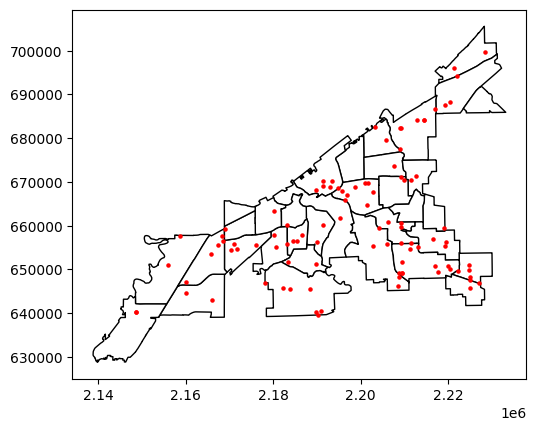

In [0]:
# Let's plot the data we just retreived, since there are hundreds of thousands of records, we will only map the first 100.
base_plot = neighborhoods_gdf.plot(color='white',edgecolor='black')
crashes_gdf.head(100).plot(ax=base_plot,color='red',markersize=5)

#### Step 3: Perform a spatial join between crashes and neighborhoods
Say we want to know how many crashes happen in each neighborhood. Currently, the `crashes_gdf` GeoDataFrame does not contain any information about what neighborhood it's in. Furthermore, the `neighborhoods_gdf` doesn't have any information about the number of crashes in each neighborhood. Therefore, we have to combine these datasets together using what is known as a [*spatial join*](https://en.wikipedia.org/wiki/Spatial_join).  

With `geopandas`, we can perform a spatial join using the [`geopandas.sjoin()`](https://geopandas.org/en/stable/docs/reference/api/geopandas.sjoin.html) function. The `sjoin` function works similarly to a standard table join. We input two `GeoDataFrames` that we want to join together as either a *left*, *right*, or *inner* join. 

Next, we define the *predicate* we want to use for the join. The *predicate* is effectively the spatial operation we use to link the two datasets together. In the case of this example, we want to know how many crashes are *inside* each neighborhood. Therefore, we will use the *contains* predicate. The *contains* predicate will only join a crash point to a neighborhood polygon if it is completely inside the neighborhood polygon.


In [0]:
# Perform the spatial join with `.sjoin` method of geopandas
crash_neighborhood_join = gpd.sjoin(left_df=neighborhoods_gdf,
                                    right_df=crashes_gdf,
                                    how='left',
                                    predicate='contains')

crash_neighborhood_join.head()

,SPANM,geometry,index_right,OBJECTID,CRASH_YR,FUNCTIONAL_CLASS_CD
0,North Shore Collinwood,"MULTIPOLYGON (((2228297.801 705482.512, 222832...",7154,7155,2017.0,1.0
0,North Shore Collinwood,"MULTIPOLYGON (((2228297.801 705482.512, 222832...",126967,126968,2016.0,1.0
0,North Shore Collinwood,"MULTIPOLYGON (((2228297.801 705482.512, 222832...",152275,310661,2022.0,1.0
0,North Shore Collinwood,"MULTIPOLYGON (((2228297.801 705482.512, 222832...",130754,130755,2016.0,1.0
0,North Shore Collinwood,"MULTIPOLYGON (((2228297.801 705482.512, 222832...",113359,113360,2015.0,1.0


#### Step 4: Map the data by neighborhood
Now that we've spatially joined the crashes dataset to the neighborhoods dataset, we can begin to answer the question "how many crashes occurred in each neighborhood". One good way to approach this question is through creating a [choropleth map](https://venngage.com/blog/choropleth-map/#:~:text=A%20choropleth%20map%20is%20a,relation%20to%20a%20data%20variable.). Choropleth maps are commonly used to represent numeric data in a geographic space.  

Before we create the choropleth, we have to organize our data by neighborhood. We can achieve this by using the `DataFrame.groupby()`, and then the `.count()` function.  

*Note*: When you use `groupby()` on a `GeoDataFrame`, the `GeoDataFrame` will be converted back to a regular pandas `DataFrame`. Therefore, we have to "re-convert" the `DataFrame` back into a `GeoDataFrame`.

In [0]:
neighborhoods_grouped_gdf = crash_neighborhood_join.groupby(['SPANM','geometry'],as_index=False).count()
neighborhoods_grouped_gdf = gpd.GeoDataFrame(neighborhoods_grouped_gdf,geometry='geometry')
neighborhoods_grouped_gdf.head()

,SPANM,geometry,index_right,OBJECTID,CRASH_YR,FUNCTIONAL_CLASS_CD
0,Bellaire-Puritas,"MULTIPOLYGON (((2166865.373 648881.199, 216750...",6235,6235,6235,5926
1,Broadway-Slavic Village,"MULTIPOLYGON (((2200991.024 662326.916, 220100...",7882,7882,7882,7464
2,Brooklyn Centre,"MULTIPOLYGON (((2189462.787 655578.785, 218936...",5372,5372,5372,5168
3,Buckeye-Shaker Square,"MULTIPOLYGON (((2214621.091 667218.541, 221679...",3180,3180,3180,2937
4,Buckeye-Woodhill,"MULTIPOLYGON (((2214257.275 663095.179, 221426...",2327,2327,2327,2203


Now that we've prepped our data, we can create a choropleth map using the [`GeoDataFrame.plot()`](https://geopandas.org/en/stable/docs/user_guide/mapping.html) function.

<Axes: >

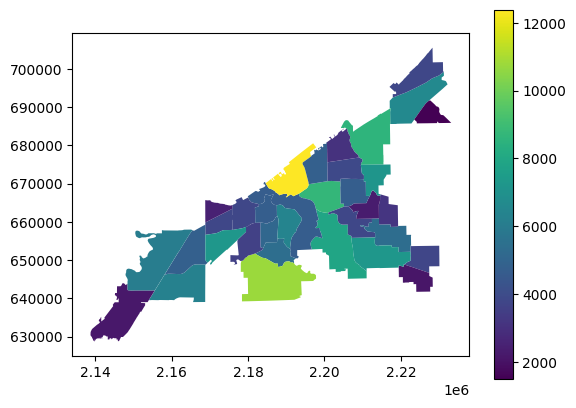

In [0]:
neighborhoods_grouped_gdf.plot(column="index_right", legend=True)

Based on the results from the choropleth, we can see that Downtown experiences the most crashes.

#### Step 5: Plot trends in data over time
Since we know which crashes happened in which neighborhood, we can perform some additional analysis on the data. Let's say we want to learn more about how trends in crash frequency has changed over time. We can use the `seaborn` package to easily visualize this information on a line chart.  

Before we visualize the data, we need to prepare it into the appropriate shape. We will do this in the following steps:
1. Filter for records where `FUNCTIONAL_CLASS_CD != 1`. The `FUNCTIONAL_CLASS_CD` column represents the type of road on which the crash occurred. In this case, we are only interested in crashes that ocurred on local streets. A `FUNCTIONAL_CLASS_CD` value of 1 means that the street is a highway. Therefore, we want to filter out these records.
2. Group the data by the year and neighborhood in which the crash ocurred. This is done with the `CRASH_YR` and `SPANM` columns respectively. 
3. Count the number of records in each group.

In [0]:
neighborhood_analysis =(
# Filter for crashes not occuring on interstates irrelevant to local context
crash_neighborhood_join[crash_neighborhood_join["FUNCTIONAL_CLASS_CD"] != 1]\
.groupby(["CRASH_YR",'SPANM'], as_index=False)\
.count()
)

neighborhood_analysis.head()

,CRASH_YR,SPANM,geometry,index_right,OBJECTID,FUNCTIONAL_CLASS_CD
0,2012.0,Bellaire-Puritas,266,266,266,266
1,2012.0,Broadway-Slavic Village,354,354,354,354
2,2012.0,Brooklyn Centre,223,223,223,223
3,2012.0,Buckeye-Shaker Square,178,178,178,178
4,2012.0,Buckeye-Woodhill,147,147,147,147


For the sake of simplicity, we will only look at the trends for 3 specific neighborhoods: Downtown, Glenville, and Old Brooklyn.

In [0]:
focus_df = neighborhood_analysis[neighborhood_analysis['SPANM'].isin(['Downtown', 'Glenville', 'Old Brooklyn'])]

Now that we've prepped the data, we can plot it using the [`seaborn.lineplot()`](https://seaborn.pydata.org/generated/seaborn.lineplot.html) function. We will tune the chart using the following parameters:
1. `data = focus_df`, this is the dataset we want to build the chart off of.
2. `x='CRASH_YEAR'` is the column that will create the X axis. In this case, it is the year the crash ocurred.
3. `y='OBJECTID'` is the column that will create the Y axis. In this case, it is the count of crashes that ocurred. Since we used `groupby` and `count` earlier in the process, the `OBJECTID` column is an aggregated count of all crashes by year and neighborhood.
4. `hue='SPANM'` is the value by which each line will be colored. In this case, it is the neighborhood in which each crash ocurred.

<Axes: xlabel='CRASH_YR', ylabel='OBJECTID'>

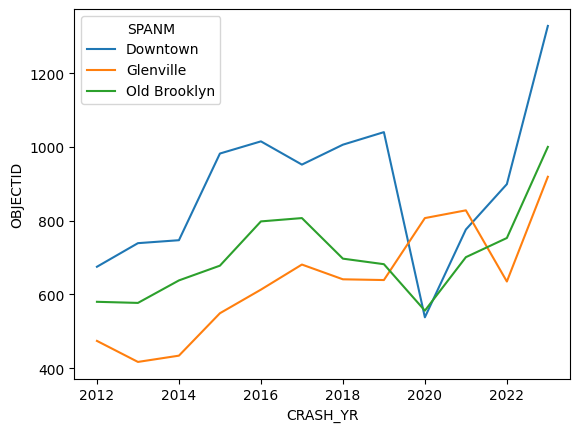

In [0]:
sns.lineplot(data=focus_df, x='CRASH_YR', y='OBJECTID', hue='SPANM')

Based on the results of the analysis, we can see that crashes were increasing across the board from 2012 to 2020. Then, when COVID hit, crashes both in Downtown and Old Brooklyn plummeted. However, in Glenville, the number of crashes actually increased. Since then, crash numbers have generally increased back to or beyond pre-pandemic levels. I think there are some interesting questions that come from these results:
1. Why did crashes in Glenville increase during COVID? And why did they fall between 2021 and 2022?
2. Why have crashes Downtown increased significantly post-COVID?